# MLP with MNIST Dataset with Triplet Loss

## 1. Import Library

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## 2. Load MNIST Dataset

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist['data'].values
y = mnist['target'].astype(np.int32).values

# Normalize the data
X = X / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.1. Show Image

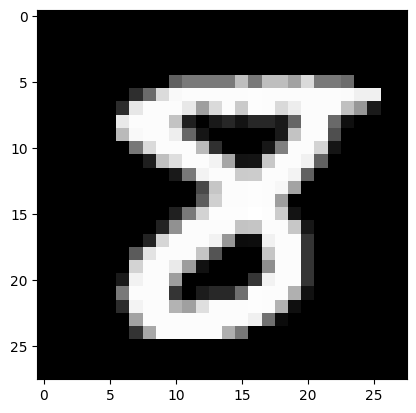

In [3]:
import matplotlib.pyplot as plt
image = X_test[0].reshape((28, 28))
plt.imshow(image, cmap='gray')
plt.show()

In [4]:
y_test[0]

8

## 3. MLP Model

### 3.1. Utils

In [5]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Computes the Triplet Loss for multiple anchors, positives, and negatives.

    Parameters:
    - anchor: np.ndarray, feature vector of the anchors.
    - positive: np.ndarray, feature vector of the positive.
    - negative: np.ndarray, feature vector of the negative.
    - margin: float, margin for calculating the loss.

    Returns:
    - total_loss: float, the value of the triplet loss.
    """
    # Compute the squared distance between the anchor and the positive example
    pos_dist = np.sum(np.square(anchor - positive), axis=-1)

    # Compute the squared distance between the anchor and the negative example
    neg_dist = np.sum(np.square(anchor - negative), axis=-1)

    # Compute the Triplet Loss
    loss = np.maximum(0, pos_dist - neg_dist + margin)

    return loss

def load_data():
    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    X = mnist['data'].values
    y = mnist['target'].astype(np.int32).values

    # Normalize the data
    X = X / 255.0

    # Binarize the labels
    y = (y == 0).astype(np.int32)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ensure the data is in the right shape for MLP (N, D) where N is number of samples, D is number of features
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    return X_train, X_test, y_train, y_test

def create_triplets(X, y, batch_size):
    """
    Create triplets (anchor, positive, negative) for training.

    Parameters:
    - X: np.ndarray, feature vectors of the samples
    - y: np.ndarray, labels of the samples
    - batch_size: int, number of triplets in the batch

    Returns:
    - anchor: np.ndarray, anchor samples
    - positive: np.ndarray, positive samples
    - negative: np.ndarray, negative samples
    """
    anchor, positive, negative = [], [], []
    for _ in range(batch_size):
        # Select anchor sample
        idx = np.random.randint(0, len(X))
        anchor.append(X[idx])

        # Select positive sample (different sample of the same class)
        pos_idxs = np.where(y == y[idx])[0]
        pos_idx = np.random.choice(pos_idxs[pos_idxs != idx])
        positive.append(X[pos_idx])

        # Select negative sample (sample of a different class)
        neg_idxs = np.where(y != y[idx])[0]
        neg_idx = np.random.choice(neg_idxs)
        negative.append(X[neg_idx])

    return np.array(anchor), np.array(positive), np.array(negative)

def extract_label_features(model, X_train, y_train):
    # Extract one sample for each label
    unique_labels = np.unique(y_train)
    label_samples = {label: X_train[np.where(y_train == label)[0][0]] for label in unique_labels}

    # Extract features for each label sample
    label_features = {label: model.forward(sample) for label, sample in label_samples.items()}

    # Store the features in a list
    label_features_list = [label_features[label] for label in unique_labels]

    return label_features_list, unique_labels

def cosine_similarity(v1, v2):
    """
    Compute the cosine similarity between two vectors.

    Parameters:
    - v1: np.ndarray, first vector
    - v2: np.ndarray, second vector

    Returns:
    - similarity: float, cosine similarity score
    """
    dot_product = np.dot(v1, v2.T)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    similarity = dot_product / (norm_v1 * norm_v2)
    return similarity

### 3.2. Architecture

In [6]:
import numpy as np

class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2

    def compute_loss(self, anchor, positive, negative, alpha=0.2):
        anchor_output = self.forward(anchor)
        positive_output = self.forward(positive)
        negative_output = self.forward(negative)

        # Ensure there are no NaN values in outputs
        if np.isnan(anchor_output).any() or np.isnan(positive_output).any() or np.isnan(negative_output).any():
            print("NaN detected in forward pass outputs")

        loss = triplet_loss(anchor_output, positive_output, negative_output, alpha)
        return loss

    def backward(self, anchor, positive, negative, alpha=0.2, learning_rate=0.01):
        # Forward pass
        anchor_output = self.forward(anchor)
        positive_output = self.forward(positive)
        negative_output = self.forward(negative)

        # Calculate gradients (simple backpropagation)
        pos_dist = 2 * (anchor_output - positive_output)
        neg_dist = 2 * (anchor_output - negative_output)

        dloss_da = pos_dist - neg_dist
        dloss_dp = -pos_dist
        dloss_dn = neg_dist

        # Ensure there are no NaN values in gradients
        if np.isnan(dloss_da).any() or np.isnan(dloss_dp).any() or np.isnan(dloss_dn).any():
            print("NaN detected in gradients")

        # Update weights and biases (simplified gradient descent)
        self.W2 -= learning_rate * np.dot(self.a1.T, dloss_da)
        self.b2 -= learning_rate * np.sum(dloss_da, axis=0, keepdims=True)

        dW1_a = np.dot(anchor.T, np.dot(dloss_da, self.W2.T) * (self.z1 > 0))
        db1_a = np.sum(np.dot(dloss_da, self.W2.T) * (self.z1 > 0), axis=0, keepdims=True)

        dW1_p = np.dot(positive.T, np.dot(dloss_dp, self.W2.T) * (self.z1 > 0))
        db1_p = np.sum(np.dot(dloss_dp, self.W2.T) * (self.z1 > 0), axis=0, keepdims=True)

        dW1_n = np.dot(negative.T, np.dot(dloss_dn, self.W2.T) * (self.z1 > 0))
        db1_n = np.sum(np.dot(dloss_dn, self.W2.T) * (self.z1 > 0), axis=0, keepdims=True)

        self.W1 -= learning_rate * (dW1_a + dW1_p + dW1_n)
        self.b1 -= learning_rate * (db1_a + db1_p + db1_n)

## 4. Train

In [7]:
input_size = 28 * 28
hidden_size = 128
output_size = 64
model = MLP(input_size, hidden_size, output_size)

In [8]:
learning_rate = 0.01
num_epochs = 10
batch_size = 32

In [9]:
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = len(X_train) // batch_size

    for _ in range(num_batches):
        # Create triplet batches
        anchor, positive, negative = create_triplets(X_train, y_train, batch_size)

        # Compute loss
        loss = model.compute_loss(anchor, positive, negative)
        epoch_loss += np.sum(loss)

        # Backward pass and update weights
        model.backward(anchor, positive, negative, learning_rate)

    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training completed.")

Epoch 1/10, Loss: 6.3979
Epoch 2/10, Loss: 6.4000
Epoch 3/10, Loss: 6.4000
Epoch 4/10, Loss: 6.4000
Epoch 5/10, Loss: 6.4000
Epoch 6/10, Loss: 6.4000
Epoch 7/10, Loss: 6.4000
Epoch 8/10, Loss: 6.4000
Epoch 9/10, Loss: 6.4000
Epoch 10/10, Loss: 6.4000
Training completed.


## 5. Inference & Evaluate

In [27]:
def inference(model, input):
    # Load the data
    X_train, X_test, y_train, y_test = load_data()
    label_features_list, unique_labels = extract_label_features(model, X_train, y_train)

    # Extract features from the input sample
    input_features = model.forward(input)

    # Calculate similarity scores with each label feature
    similarities = [cosine_similarity(input_features, label_feature) for label_feature in label_features_list]

    # Find the label with the highest similarity score
    predicted_label = unique_labels[np.argmax(similarities)]

    return predicted_label

In [28]:
input_sample = X_test[0]  # Example input sample from test set
predicted_label = inference(model, input_sample)
print(f"Predicted Label: {predicted_label}, True Label: {y_test[0]}")

Predicted Label: 1, True Label: 8
